In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

from google.colab import drive

###Mount google Drive###

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Read and Select COVID-19 Records for india and fill null values with zeros###

In [3]:
df = pd.read_csv('/content/drive/My Drive/Datasets/owid-covid-data.csv')
df['date'] = pd.to_datetime(df['date'])
df.index = df.date
#df=df[(df['continent']=='Asia') & (df['location']=='India')][['date','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality']]
df=df[(df['continent']=='Asia') & (df['location']=='India') & (df['date']<'01/01/2022')][['date','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality']]
df.fillna(0, inplace=True)
df = df[['date','new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
#df['date'] = pd.to_datetime(df['date'])
#df.index = df.date

df.tail()

,date,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,,
2021-12-27,2021-12-27,6358.0,293.0,939539.0,0.0,0.0
2021-12-28,2021-12-28,9195.0,302.0,1141910.0,0.0,0.0
2021-12-29,2021-12-29,13154.0,268.0,1167612.0,0.0,0.0
2021-12-30,2021-12-30,16764.0,220.0,1199252.0,0.0,0.0
2021-12-31,2021-12-31,22775.0,406.0,1432860.0,0.0,0.0


Searcing for non-numeric rows

In [4]:
#pd.to_numeric(df['new_cases'], errors='coerce').notnull().all()
#pd.to_numeric(df['positive_rate'], errors='coerce').notnull().all()
#pd.to_numeric(df['new_deaths'], errors='coerce').notnull().all()
#pd.to_numeric(df['new_tests'], errors='coerce').notnull().all()
#pd.to_numeric(df['icu_patients'], errors='coerce').notnull().all()
#pd.to_numeric(df['hosp_patients'], errors='coerce').notnull().all()
df.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

date             True
new_cases        True
new_deaths       True
new_tests        True
icu_patients     True
hosp_patients    True
dtype: bool

Convert float64 to int64 in panda series

In [5]:
df['new_cases'] = df['new_cases'].astype('Int64')
df['new_deaths'] = df['new_deaths'].astype('Int64')
df['new_tests'] = df['new_tests'].astype('Int64')
df['icu_patients'] = df['icu_patients'].astype('Int64')
df['hosp_patients'] = df['hosp_patients'].astype('Int64')

First 5 tuples of the Data Frame

In [6]:
df.head()

,date,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,,
2020-01-30,2020-01-30,1,0,0,0,0
2020-01-31,2020-01-31,0,0,0,0,0
2020-02-01,2020-02-01,0,0,0,0,0
2020-02-02,2020-02-02,1,0,0,0,0
2020-02-03,2020-02-03,1,0,0,0,0


Last 5 tuples of the Data Frame 

In [7]:
df.tail()

,date,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,,
2021-12-27,2021-12-27,6358,293,939539,0,0
2021-12-28,2021-12-28,9195,302,1141910,0,0
2021-12-29,2021-12-29,13154,268,1167612,0,0
2021-12-30,2021-12-30,16764,220,1199252,0,0
2021-12-31,2021-12-31,22775,406,1432860,0,0


#### Check the dimension of the data ####

In [8]:
df.shape

(702, 6)

###-Train-Test Splitting-###
####*Remember here we can’t shuffle the data, because it is a timeseries data so we have to follow the order!*####

In [9]:
df = df[['new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
test_split=round(len(df)*0.3)
print(len(df)-test_split)
df_for_training=df[:(len(df)-test_split)]
df_for_testing=df[(len(df)-test_split):]
print(df_for_training.shape)
print(df_for_testing.shape)


491
(491, 5)
(211, 5)


To display first 5 Records of the training data

In [10]:
df_for_training.head()

,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,
2020-01-30,1,0,0,0,0
2020-01-31,0,0,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,1,0,0,0,0
2020-02-03,1,0,0,0,0


To display last 5 Records of the testing data

In [11]:
df_for_testing.tail()

,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,
2021-12-27,6358,293,939539,0,0
2021-12-28,9195,302,1141910,0,0
2021-12-29,13154,268,1167612,0,0
2021-12-30,16764,220,1199252,0,0
2021-12-31,22775,406,1432860,0,0


If you see the data, we can notice that the data range is very high, and they are not scaled in a same range, so to avoid prediction errors let’s scale the data first using **MinMaxScaler**.

In [12]:
#print(df['date'].dtype)
#print(df['new_cases'].dtype)
#print(df['new_deaths'].dtype)
#print(df['new_tests'].dtype)
#print(df['icu_patients'].dtype)
#print(df['hosp_patients'].dtype)


scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)
df_for_training_scaled


array([[2.41436256e-06, 2.20750552e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.20750552e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 2.20750552e-04, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       ...,
       [3.20598376e-01, 7.08167770e-01, 5.16834804e-01, 0.00000000e+00,
        0.00000000e+00],
       [3.23896395e-01, 6.37527594e-01, 8.76454842e-01, 0.00000000e+00,
        0.00000000e+00],
       [3.19574686e-01, 5.99116998e-01, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

Split the data in **X** and **Y**

In [13]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past, len(dataset)):
            dataX.append(dataset[i - n_past:i, 0:dataset.shape[1]])
            dataY.append(dataset[i,0])
    return np.array(dataX),np.array(dataY)
    
trainX, trainY=createXY(df_for_training_scaled,30)
testX,testY=createXY(df_for_testing_scaled,30)

Verify **TrainX**, **TrainY** Shape

In [14]:
print("trainX Shape-- ",trainX.shape)
print("trainY Shape-- ",trainY.shape)

trainX Shape--  (461, 30, 5)
trainY Shape--  (461,)


Verify **TestX**, **TestY** Shape

In [15]:
print("testX Shape-- ",testX.shape)
print("testY Shape-- ",testY.shape)

testX Shape--  (181, 30, 5)
testY Shape--  (181,)


Let’s have a look on one of the array containing (30,5) data from **trainX** and **trainY** value for that **trainX** array

In [16]:
print("trainX[0]-- \n",trainX[0])
print("trainY[0]-- ",trainY[0])

trainX[0]-- 
 [[2.41436256e-06 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.41436256e-06 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.41436256e-06 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.20750552e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.2075055

Now lets train the model , I am using *girdsearchCV* to do some hyperparameter tuning to find the best model.

In [17]:
def build_model(optimizer):
    grid_model = Sequential()
    grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,5)))
    grid_model.add(LSTM(50))
    grid_model.add(Dropout(0.2))
    grid_model.add(Dense(1))
    grid_model.compile(loss = 'mse',optimizer = optimizer)
    return grid_model
    
grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))

parameters = {'batch_size' : [16,20],
              'epochs' : [8,10],
              'optimizer' : ['adam','Adadelta'] }

grid_search  = GridSearchCV(estimator = grid_model, param_grid = parameters, cv = 2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  # Remove the CWD from sys.path while we load stuff.


Now let’s fit the model in out **trainX** and **trainY** data.

In [18]:
grid_search = grid_search.fit(trainX,trainY)

Epoch 1/8
15/15 [==============================] - 5s 100ms/step - loss: 0.0574 - val_loss: 0.0114
Epoch 2/8
15/15 [==============================] - 1s 37ms/step - loss: 0.0196 - val_loss: 0.0035
Epoch 3/8
15/15 [==============================] - 1s 38ms/step - loss: 0.0138 - val_loss: 0.0039
Epoch 4/8
15/15 [==============================] - 1s 35ms/step - loss: 0.0056 - val_loss: 0.0012
Epoch 5/8
15/15 [==============================] - 1s 37ms/step - loss: 0.0054 - val_loss: 0.0035
Epoch 6/8
15/15 [==============================] - 1s 37ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 7/8
15/15 [==============================] - 1s 37ms/step - loss: 0.0036 - val_loss: 0.0013
Epoch 8/8
15/15 [==============================] - 0s 8ms/step - loss: 7.6107e-04
Epoch 1/8
15/15 [==============================] - 5s 95ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 2/8
15/15 [==============================] - 1s 36ms/step - loss: 7.6518e-04 - val_loss: 0.0100
Epoch 3/8
15/15 [==============

Let's check best parameters of our LSTM Model

In [19]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 8, 'optimizer': 'adam'}

Now, save the best model in my_model variable

In [20]:
my_model=grid_search.best_estimator_.model

We created our model to do the predictions for time series.
Now let’s test the model with our test data set.

In [21]:
prediction=my_model.predict(testX)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

prediction
 [[ 0.04885501]
 [ 0.05134915]
 [ 0.0502694 ]
 [ 0.05007142]
 [ 0.05331655]
 [ 0.05808498]
 [ 0.06382482]
 [ 0.07095499]
 [ 0.07534375]
 [ 0.0780858 ]
 [ 0.07953731]
 [ 0.08114374]
 [ 0.08239289]
 [ 0.08287229]
 [ 0.08313173]
 [ 0.08249484]
 [ 0.07775897]
 [ 0.08199837]
 [ 0.08630507]
 [ 0.08731252]
 [ 0.08778048]
 [ 0.08572999]
 [ 0.08268554]
 [ 0.0751008 ]
 [ 0.07085411]
 [ 0.06973659]
 [ 0.07113012]
 [ 0.07521483]
 [ 0.07945872]
 [ 0.08312704]
 [ 0.08318521]
 [ 0.08424777]
 [ 0.08722678]
 [ 0.09079296]
 [ 0.09360532]
 [ 0.09635041]
 [ 0.09786091]
 [ 0.09714472]
 [ 0.09547866]
 [ 0.0952033 ]
 [ 0.09875649]
 [ 0.10248065]
 [ 0.10607273]
 [ 0.10684229]
 [ 0.10101659]
 [ 0.09623525]
 [ 0.09289393]
 [ 0.09034503]
 [ 0.09151301]
 [ 0.0911317 ]
 [ 0.08786223]
 [ 0.08133671]
 [ 0.07836419]
 [ 0.07928241]
 [ 0.08319343]
 [ 0.08874361]
 [ 0.09546117]
 [ 0.10095635]
 [ 0.10261187]
 [ 0.10277597]
 [ 0.10458001]
 [ 0.09907893]
 [ 0.09052763]
 [ 0.09016408]
 [ 0.09440546]
 [ 0.09775434

Now, the Inverse scaling is little bit tricky, let’s try it through code

In [22]:
scaler.inverse_transform(prediction)

ValueError: ignored

So, we have to change shape to use inverse_transform

In [23]:
prediction_copies_array = np.repeat(prediction,5, axis=-1)

check the shape now

In [24]:
prediction_copies_array.shape

(181, 5)

Now we can easily use inverse_transform function

In [25]:
pred=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(prediction),5)))[:,0]

We just need the first column after inverse transform, so we used → [:,0] at the end.
Now we need to compare this pred values with testY. But our testY is also scaled. So, let’s use inverse transform with the same above codes.

In [26]:
original_copies_array = np.repeat(testY,5, axis=-1)
original=scaler.inverse_transform(np.reshape(original_copies_array,(len(testY),5)))[:,0]

Now let’s check the prediction and original values →

In [27]:
print("Pred Values-- " ,pred)
print("\nOriginal Values-- " ,original)

Pred Values--  [20235.16    21268.203   20820.982   20738.982   22083.076   24058.1
 26435.477   29388.707   31206.477   32342.2     32943.4     33608.766
 34126.15    34324.71    34432.164   34168.37    32206.832   33962.742
 35746.527   36163.797   36357.62    35508.336   34247.36    31105.852
 29346.92    28884.06    29461.242   31153.082   32910.848   34430.223
 34454.316   34894.414   36128.285   37605.355   38770.2     39907.184
 40532.816   40236.18    39546.117   39432.066   40903.754   42446.254
 43934.05    44252.793   41839.86    39859.49    38475.55    37419.83
 37903.59    37745.656   36391.48    33688.688   32457.508   32837.824
 34457.72    36756.54    39538.87    41814.91    42500.605   42568.574
 43315.79    41037.305   37495.457   37344.88    39101.61    40488.67
 42478.94    44896.992   47096.188   48435.902   48227.855   46883.246
 43923.637   40783.805   38505.99    36983.94    35954.562   35174.45
 34503.797   33256.46    32167.295   32138.412   32408.164   32720.

**Now let’s make a plot to check our pred and original data.**

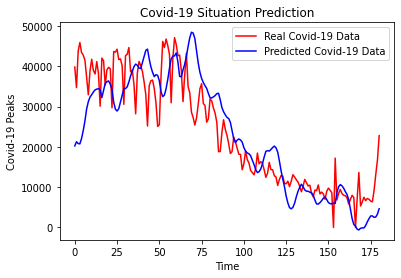

In [28]:
plt.plot(original, color = 'red', label = 'Real Covid-19 Data')
plt.plot(pred, color = 'blue', label = 'Predicted Covid-19 Data')
plt.title('Covid-19 Situation Prediction')
plt.xlabel('Time')
plt.ylabel('Covid-19 Peaks')
plt.legend()
plt.show()

Till now we trained our model, checked that model with test values.
> **Let’s now predict some future values.**

Now let’s take the last 30 values from the main ***df*** dataset what we loaded at the beginning

[Why 30? because that’s the number of past values we want, to predict the 31st value]

In [29]:
df_30_days_past=df.iloc[-30:,:]
df_30_days_past.tail()

,new_cases,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,,
2021-12-27,6358,293,939539,0,0
2021-12-28,9195,302,1141910,0,0
2021-12-29,13154,268,1167612,0,0
2021-12-30,16764,220,1199252,0,0
2021-12-31,22775,406,1432860,0,0


***We can see above that we have all the columns including target column "new_cases".***

> Now let’s predict future 30 values.

> [It is to be observed that in multivariate time series forecasting if we want to predict single column by using different features, while doing the prediction we need the feature values**(except the target column)** to do the upcoming predictions.]

**So ,** here we need the upcoming 30 values of **'new_cases', 'new_deaths', 'new_tests', 'icu_patients', 'hosp_patients'** columns to do the prediction of the **“new_cases”** column.



In [30]:
d=pd.read_csv('/content/drive/My Drive/Datasets/owid-covid-data.csv', usecols=['date','continent','location','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality'], low_memory=False) #,parse_dates=["date"],index_col=[3], usecols=['date','total_cases','new_cases','total_deaths','new_deaths','icu_patients','hosp_patients','weekly_icu_admissions','weekly_hosp_admissions','new_tests','positive_rate','tests_per_case','total_vaccinations','people_vaccinated','people_fully_vaccinated','total_boosters','new_vaccinations','cardiovasc_death_rate','diabetes_prevalence','female_smokers','male_smokers','handwashing_facilities','hospital_beds_per_thousand','excess_mortality'], low_memory=False
df_30_days_future=d
df_30_days_future['date'] = pd.to_datetime(df_30_days_future['date'])
df_30_days_future.index = df_30_days_future.date

df_30_days_future=d[(d['continent']=='Asia') & (d['location']=='India') & (d['date']>'31/12/2021')]

#df_30_days_future = df_30_days_future[['date','new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
#df_30_days_future['date'] = pd.to_datetime(df_30_days_future['date'])
#df_30_days_future.index = df_30_days_future.date

df_30_days_future = df_30_days_future[['new_deaths','new_tests','icu_patients','hosp_patients']] #'new_cases',
df_30_days_future.fillna(0, inplace=True)

#df_30_days_future['new_cases'] = df_30_days_future['new_cases'].astype('Int64')

df_30_days_future['new_deaths'] = df_30_days_future['new_deaths'].astype('Int64')
df_30_days_future['new_tests'] = df_30_days_future['new_tests'].astype('Int64')
df_30_days_future['icu_patients'] = df_30_days_future['icu_patients'].astype('Int64')
df_30_days_future['hosp_patients'] = df_30_days_future['hosp_patients'].astype('Int64')



First 5 records of 30 days future prediction records

In [31]:
df_30_days_future.head()

,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,
2022-01-01,284,1110855,0,0
2022-01-02,123,1082376,0,0
2022-01-03,124,878990,0,0
2022-01-04,534,1478119,0,0
2022-01-05,325,1388647,0,0


Last 5 records of 30 days future prediction records

In [32]:
df_30_days_future.tail()

,new_deaths,new_tests,icu_patients,hosp_patients
date,,,,
2022-01-26,573,1769745,0,0
2022-01-27,627,1594070,0,0
2022-01-28,871,1582307,0,0
2022-01-29,893,0,0,0
2022-01-30,959,0,0,0


Now we have to do some steps before doing the prediction using our model →
    
    1) We have to scale the past and future data. As you can see in our future data we don’t have “new_cases” column , so before scaling it , just add a “new_cases” column in the future data with all “0” values.
    
    2) After scaling replace the “new_cases” column value with “nan” in the future data
    
    3) Now attach the 30 days old value with 30 days new value (where last 30 “new_cases” values are nan)

In [33]:
df_30_days_future["new_cases"]=0
df_30_days_future=df_30_days_future[['new_cases','new_deaths','new_tests','icu_patients','hosp_patients']]
old_scaled_array=scaler.transform(df_30_days_past)
new_scaled_array=scaler.transform(df_30_days_future)
new_scaled_df=pd.DataFrame(new_scaled_array)
new_scaled_df.iloc[:,0]=np.nan
full_df=pd.concat([pd.DataFrame(old_scaled_array),new_scaled_df]).reset_index().drop(["index"],axis=1)

Now check the **full_df**. The shape will be **(60,5)** with ***30 NaN*** values for the first column at the end.

In [34]:
full_df

,0,1,2,3,4
0,0.022251,0.086534,0.294904,0.0,0.0
1,0.020771,0.091832,0.310619,0.0,0.0
2,0.000000,0.000221,0.364722,0.0,0.0
3,0.041529,0.664018,0.329117,0.0,0.0
4,0.016471,0.048786,0.270102,0.0,0.0
5,0.020375,0.043267,0.318885,0.0,0.0
6,0.022741,0.035320,0.325645,0.0,0.0
7,0.020285,0.081457,0.346275,0.0,0.0
8,0.019291,0.086976,0.347195,0.0,0.0
9,0.019018,0.124283,0.371448,0.0,0.0


**Now,** to do the prediction we have to use the for loop again, what we made while spliting the data in **trainX** and **trainY**. But this time we have only ***X***, no ***Y*** value is there:

In [35]:
full_df_scaled_array=full_df.values
all_data=[]
time_step=30
for i in range(time_step,len(full_df_scaled_array)):
    data_x=[]
    data_x.append(full_df_scaled_array[i-time_step :i , 0:full_df_scaled_array.shape[1]])
    data_x=np.array(data_x)
    prediction=my_model.predict(data_x)
    all_data.append(prediction)
    full_df.iloc[i,0]=prediction

In the the above code for the first prediction we have previous 30 values. Which means, when the for loop run for the first time, it checked the previous 30 values and predict the 31st **“new_cases”** data.

**But** when the 2nd for loop will try to run, it will skip first row and try to get next 30 values means [1:31] , here we will start getting error as in the last row for the open column we have **“NaN”**, so we have replace the **“NaN”** with the prediction each time.

**Now,** let’s do the inverse transform on our prediction to check the real value like we did before →

In [36]:
new_array=np.array(all_data)
new_array=new_array.reshape(-1,1)
prediction_copies_array = np.repeat(new_array,5, axis=-1)
y_pred_future_30_days = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(new_array),5)))[:,0]
Future_list_30days=y_pred_future_30_days.tolist()
print('30 days prediction:')
for i in Future_list_30days:
  print(i)

30 days prediction:
7289.85595703125
9085.7578125
10017.009765625
9928.23828125
10716.9521484375
11769.9130859375
12982.3056640625
14215.2392578125
15630.56640625
16707.23828125
17534.77734375
18088.466796875
20223.71875
18339.87890625
15007.5791015625
14197.7109375
15123.537109375
15968.6259765625
17508.849609375
20031.56640625
22911.908203125
26085.712890625
28747.248046875
31036.8984375
32026.232421875
33125.61328125
34112.33984375
34709.71484375
35359.9453125
33029.9765625


#Thus, We predicted 30 future values….